In [60]:
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy

import librosa # For analyzing audio and music, extracting the data from the audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio # To play the audio files

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import concurrent.futures
# Import required libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Import necessary libraries for scaling and splitting
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Data Preparation

In [61]:
data_df=pd.read_csv(r"C:\Users\asus\Desktop\SpeechSentemintAnalysis\data\input\combinedfor1d.csv")

In [62]:
# Preparing the features and labels
X = data_df.iloc[:, :-1].values
y = data_df['Labels'].values

In [63]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [64]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [65]:
# Printing the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40383, 154) (40383, 7) (13461, 154) (13461, 7)


In [66]:
# Scaling the data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Printing the shapes of the scaled data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40383, 154) (40383, 7) (13461, 154) (13461, 7)


# Evaluation functions

In [68]:
def plot_loss_accuracy_curves(history):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylabel("loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [69]:

def display_metrics(model1, X_test, y_test, class_names=None):
    # Predict validation data
    y_test_pred = model1.predict(X_test)
    y_test_pred_class = (y_test_pred > 0.5).astype("int32")

    # Calculate overall metrics
    accuracy = accuracy_score(y_test, y_test_pred_class)
    precision = precision_score(y_test, y_test_pred_class, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_test_pred_class, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred_class, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    # Print overall metrics
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score (weighted average): {f1:.4f}')
    print(f'ROC AUC (macro average):     {roc_auc:.4f}')
    print()

    # Print individual F1 scores per class
    print("Per-Class F1 Scores:")
    report = classification_report(y_test, y_test_pred_class, target_names=class_names, zero_division=0, output_dict=True)
    for cls in class_names:
        f1_class = report[cls]['f1-score']
        print(f'{cls:10s}: F1 Score = {f1_class:.4f}')


In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_multiclass_confusion_matrix(model, X_test, y_test, class_names):
    """
    Treats multi-label classification as multi-class by selecting the highest probability class.
    Plots a standard confusion matrix.
    """
    # Predict the probabilities
    y_pred_probs = model.predict(X_test)

    # Convert predictions and ground truth to single-label (argmax)
    y_pred_single = np.argmax(y_pred_probs, axis=1)
    y_true_single = np.argmax(y_test, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_true_single, y_pred_single)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Multi-Class Confusion Matrix (One Label per Sample)", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

# Function to plot ROC curve for multilabel classification
def plot_roc_curve(model1, X_test, y_test):
    y_test_pred = model1.predict(X_test)

    # Plot ROC curve for each label
    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc = roc_auc_score(y_test[:, i], y_test_pred[:, i])
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for label {i}')
        plt.legend(loc='best')
        plt.show()

# ANN Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [45]:
model1 = Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

In [46]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
history1 = model1.fit(X_train, y_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train)//32, validation_data=(X_test, y_test), validation_steps=len(X_test))

Epoch 1/100


1261/1261 [==============================] - 5s 2ms/step - loss: 1.4076 - accuracy: 0.4429 - val_loss: 1.3430 - val_accuracy: 0.4872
Epoch 2/100
1261/1261 [==============================] - 3s 2ms/step - loss: 1.1839 - accuracy: 0.5338
Epoch 3/100
1261/1261 [==============================] - 3s 2ms/step - loss: 1.0900 - accuracy: 0.5686
Epoch 4/100
1261/1261 [==============================] - 4s 3ms/step - loss: 1.0401 - accuracy: 0.5895
Epoch 5/100
1261/1261 [==============================] - 3s 2ms/step - loss: 1.0094 - accuracy: 0.6001
Epoch 6/100
1261/1261 [==============================] - 2s 2ms/step - loss: 0.9829 - accuracy: 0.6115
Epoch 7/100
1261/1261 [==============================] - 2s 2ms/step - loss: 0.9658 - accuracy: 0.6171
Epoch 8/100
1261/1261 [==============================] - 2s 2ms/step - loss: 0.9469 - accuracy: 0.6229
Epoch 9/100
1261/1261 [==============================] - 2s 2ms/step - loss: 0.9317 - accuracy: 0.6330
Epoch 10/100
1261/1261 [=====

## Evaluate ANN Model

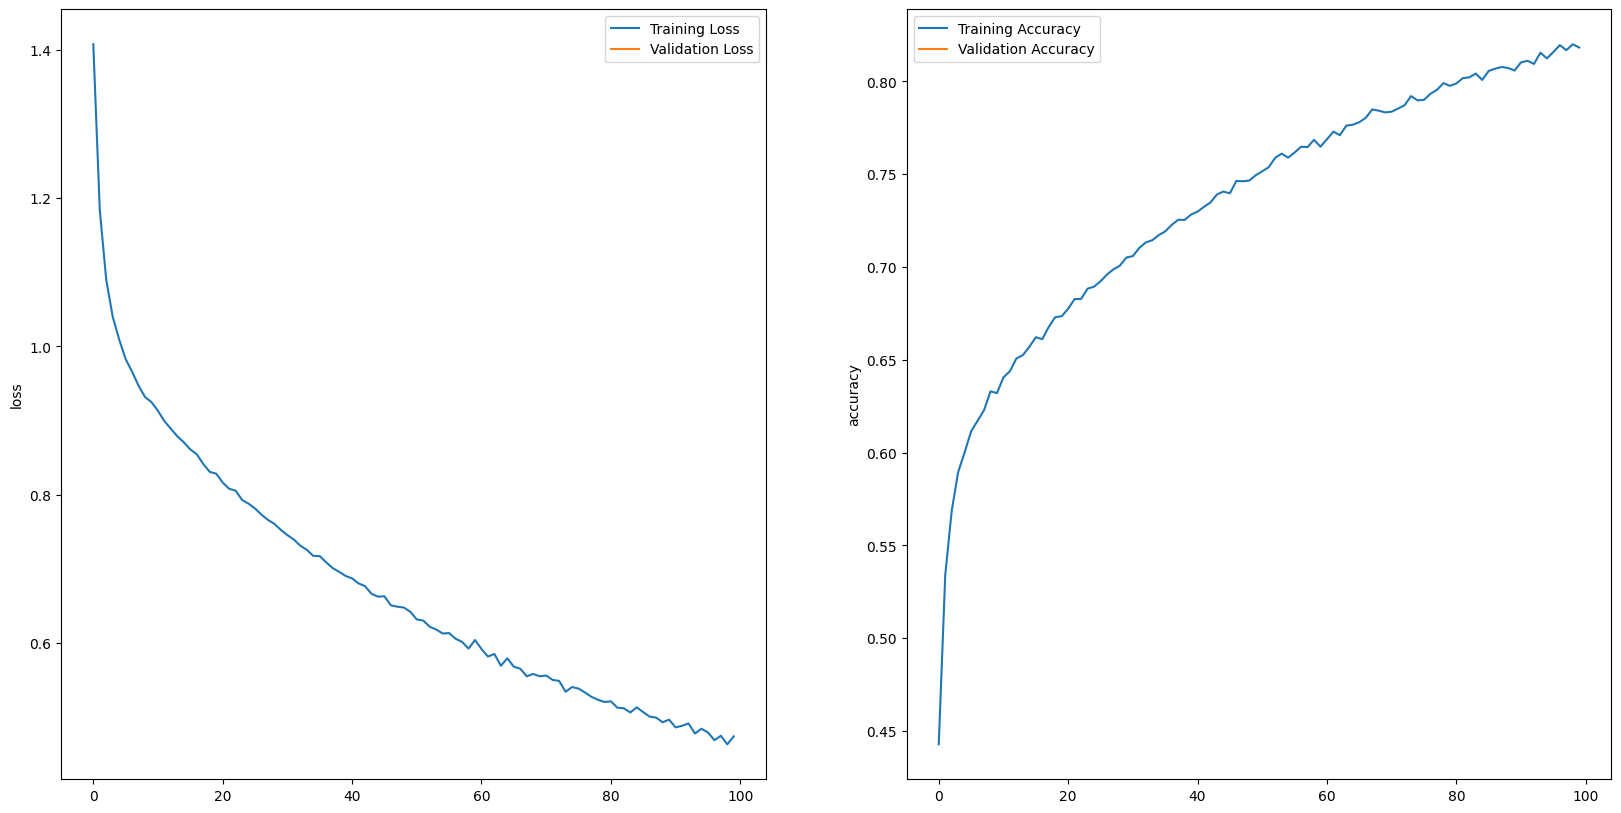

In [48]:
plot_loss_accuracy_curves(history1)

In [72]:
emotion_classes = ['happy', 'sad', 'angry', 'fear', 'disgust', 'calm', 'surprise']

display_metrics(model1, X_test, y_test, class_names=emotion_classes)


421/421 [==============================] - 1s 1ms/step
Accuracy:  0.6783
Precision: 0.7966
Recall:    0.6783
F1 Score (weighted average): 0.7286
ROC AUC (macro average):     0.9508

Per-Class F1 Scores:
happy     : F1 Score = 0.8242
sad       : F1 Score = 0.6758
angry     : F1 Score = 0.6452
fear      : F1 Score = 0.6357
disgust   : F1 Score = 0.6815
calm      : F1 Score = 0.6730
surprise  : F1 Score = 0.9495


421/421 [==============================] - 1s 1ms/step


<Figure size 800x600 with 0 Axes>

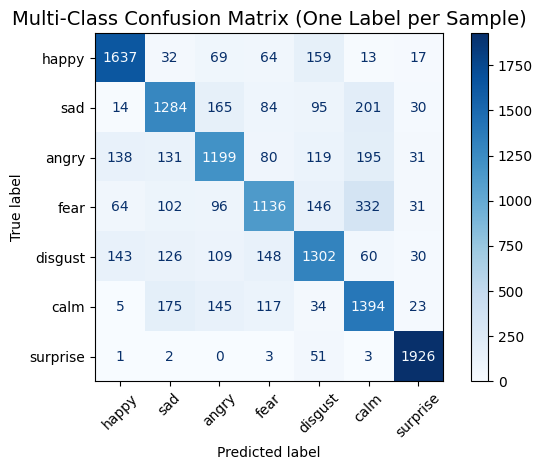

In [73]:
plot_multiclass_confusion_matrix(model1, X_test, y_test, emotion_classes)


## Save Model

In [77]:
model1.save("../../Models/1D_ANN_CNN_Aprouch/ANN_model.h5")
print("Model saved as .h5 file")

# Method 2: Save with explicit format specification
model1.save("../../Models/1D_ANN_CNN_Aprouch/ANN_model.keras", save_format='keras')
print("Model saved as .keras file with explicit format")


Model saved as .h5 file
Model saved as .keras file with explicit format


# CNN Model

In [78]:
model2=Sequential()
model2.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model2.add(Dropout(0.2))

model2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(7, activation='softmax'))

In [79]:
model2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [80]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=3, min_lr=0.0000001)
history2=model2.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/100
631/631 [==============================] - 78s 120ms/step - loss: 1.5410 - accuracy: 0.3899 - val_loss: 1.3500 - val_accuracy: 0.4722 - lr: 0.0010
Epoch 2/100
631/631 [==============================] - 71s 112ms/step - loss: 1.2863 - accuracy: 0.4989 - val_loss: 1.1919 - val_accuracy: 0.5438 - lr: 0.0010
Epoch 3/100
631/631 [==============================] - 64s 101ms/step - loss: 1.1586 - accuracy: 0.5488 - val_loss: 1.0515 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 4/100
631/631 [==============================] - 68s 108ms/step - loss: 1.0946 - accuracy: 0.5730 - val_loss: 1.0033 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 5/100
631/631 [==============================] - 80s 126ms/step - loss: 1.0531 - accuracy: 0.5883 - val_loss: 0.9923 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 6/100
631/631 [==============================] - 73s 116ms/step - loss: 1.0283 - accuracy: 0.5982 - val_loss: 0.9946 - val_accuracy: 0.6131 - lr: 0.0010
Epoch 7/100
631/631 [=========================

## Evaluate Model

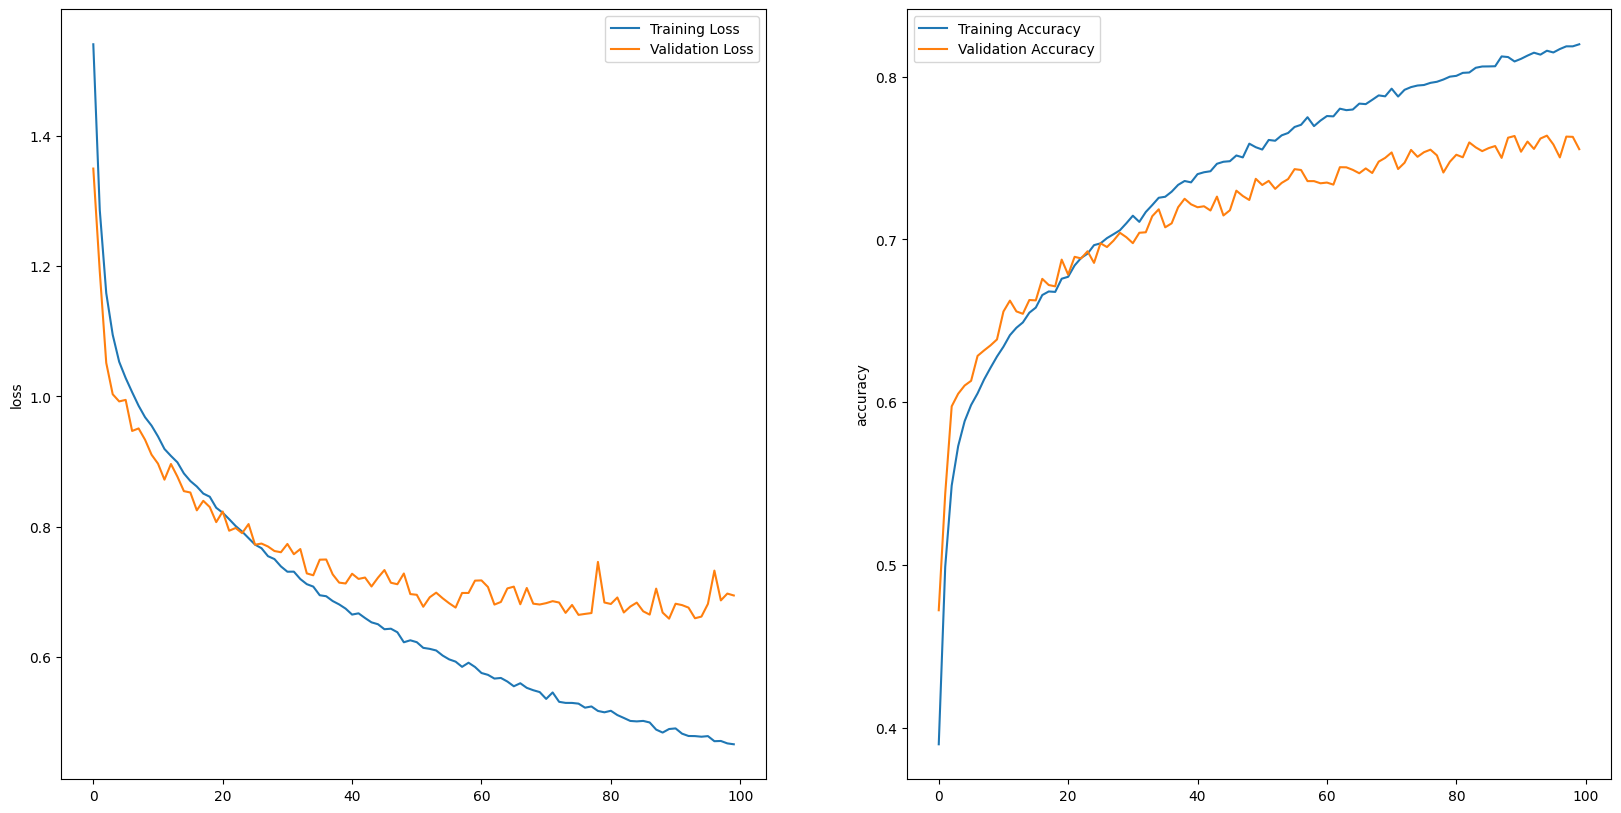

In [81]:
plot_loss_accuracy_curves(history2)

In [82]:
display_metrics(model1, X_test, y_test, class_names=emotion_classes)


421/421 [==============================] - 1s 2ms/step
Accuracy:  0.6783
Precision: 0.7966
Recall:    0.6783
F1 Score (weighted average): 0.7286
ROC AUC (macro average):     0.9508

Per-Class F1 Scores:
happy     : F1 Score = 0.8242
sad       : F1 Score = 0.6758
angry     : F1 Score = 0.6452
fear      : F1 Score = 0.6357
disgust   : F1 Score = 0.6815
calm      : F1 Score = 0.6730
surprise  : F1 Score = 0.9495


421/421 [==============================] - 9s 22ms/step


<Figure size 800x600 with 0 Axes>

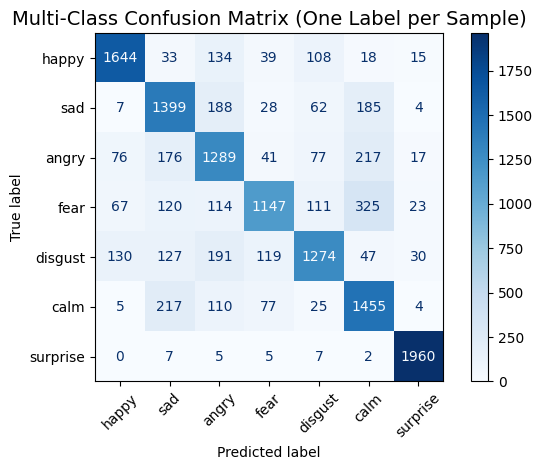

In [83]:
plot_multiclass_confusion_matrix(model2, X_test, y_test, emotion_classes)


## Save Model

In [84]:
model1.save("../../Models/1D_ANN_CNN_Aprouch/CNN_model.h5")
print("Model saved as .h5 file")

# Method 2: Save with explicit format specification
model1.save("../../Models/1D_ANN_CNN_Aprouch/CNN_model.keras", save_format='keras')
print("Model saved as .keras file with explicit format")


Model saved as .h5 file
Model saved as .keras file with explicit format
